In [2]:
#!/usr/bin/ennu python
# coding: utf-8

import numpy as np
import scipy as sp

import pandas as pd

import matplotlib.pyplot as plt

from scipy import interpolate
from scipy.integrate import simps,trapz
import scipy.constants as _con

## Helper functions 
From Jeff

In [6]:
# constants
k = _con.k  # Boltzmann constant (J/K)
c = _con.c  # Speed of light (m/s)
h = _con.h  # Planck's Constant (J-s)

# physics utility functions
def n_occ (T,v):
    """Photon mode occupation number of a black body of temperature T at frequency v"""
    return 1./(np.exp(h*v/(k*T))-1)

def IBlackBody (T, v, pol=False):
    """Planck's Law spectral radiance - radiated power (in the normal direction) per steradian
    per square meter per Hertz at frequency nu - for a blackbody at temperature T.
    If pol=True, returns for one polarization (half the power of the standard expression)."""
    polfactor = 1 if pol else 2
    return polfactor * h/(c**2)*(v**3)*n_occ(T,v)

def PBBSingleModed (T, v1=0, v2=np.inf, pol=False):
    """Planck's Law radiative power received by an ideal single-moded
    receiver sensitive over frequency band [v1,v2] observing a blackbody at temperature T.
    If pol=True, returns for one polarization (half the power of the standard expression)."""
    (out,err) = quad(lambda v: IBlackBody(T,v,pol=pol)*(c/v)**2, v1, v2)
    return out

def NEP_photon (T,eta,v1=0,v2=np.inf, pol=False, narrow=False):
    """Photon NEP [W/rtHz] for a noiseless detector observing temperature T
    with quantum efficiency eta over a frequency band [v1,v2].
    Defined with an integral to hander wider bands; faster with narrow=True."""
    polfactor = 1 if pol else 2 # sum incoherently over two polarization modes
    if narrow:
        v0 = (v1+v2)/2.
        dnu = (v2-v1)
        return np.sqrt(2*polfactor)*h*v0*np.sqrt(dv*eta*n_occ(T,v0)*(1+eta*n_occ(T,v0)))
    else:
        integrand = lambda v: eta*(h*v)**2*n_occ(T,v) + (eta*h*v*n_occ(T,v))**2
        # integrate and incorporate the factor of 2 from NEP definition
        return np.sqrt(2*polfactor*quad(integrand,v1,v2)[0])

#### Optical Elements

In [3]:
class Element:
    """
    The base class for all optical elements in the stack.
    """
    def __init__(self, name, emissivity=None, emis_func=None, self_source=None, \
                 reflection=None, refl_source=None,\
                 spillage=None, spill_func=None, spill_source=None,):
        self.name = name
        self.self_source = self_source
        self.spillage = spillage
        self.spill_func = spill_func
        self.spill_source = spill_source
        self.reflection  = reflection
        self.refl_source = refl_source
        self.efficiency = None
        self.emissivity = emissivity
        self.emis_func = emis_func

    def emis(self, v):
        if self.emissivity is not None:
            return self.emissivity * np.ones(v.shape)
        else:
            return self.emis_func(v)
        
    def spill(self, v):
        if self.spillage is not None:
            return self.spillage * np.ones(v.shape)
        else:
            return self.spill_func(v)


class Mirror(Element):
    """
    A subclass for Mirror which has transmission equals to 0
    """
    def __init__(self, name, **kwargs):
        super().__init__(name, **kwargs)

    def transfer(self, v):
        return 1 - self.emis(v)

class Grating(Mirror):
    """
    A subclass for Grating 
    """
    def __init__(self, name, **kwargs):
        super().__init__(name, **kwargs)

    def transfer(self, v):
        return 1 - self.emis(v)
        

class Filter(Element):
    """
    A subclass of Element that adds specific properties for a filter,
    """
    def __init__(self, name, transmission=None, trans_func=None, **kwargs):
        super().__init__(name, **kwargs)
        self.transmission = transmission
        self.trans_func = trans_func
    
    def trans(self, v):
        if self.transmission is not None:
            return self.transmission * np.ones(v.shape)
        elif self.trans_func is not None:
            return self.trans_func(v)
        else:
            trans = 1 - self.refl(v) - self.emis(v) 
            if np.any(trans<0):
                raise ValueError("Can't have negative transmission.")
            return trans
        
    def refl(self, v):
        if self.reflection is None:
            refl = 1 - self.trans(v) - self.emis(v) 
            if np.any(refl<0):
                raise ValueError("Can't have negative reflectivity in " +self.name)
        else:
            refl = self.reflection * np.ones(v.shape)
        return refl
        
    def transfer(self, v):
        return self.trans(v)
    

class Source(Element):
    """
    A subclass of Element that encapsulates all sources in the model and provides a method to get the
    radiance of the source.
    """
    def __init__(self, name, ):
        super().__init__(name)


class BB(Source):
    def __init__(self, name, T=300):
        super().__init__(name)
        self.T = T 

    def get_radiance(self, v):
        return IBlackBody(self.T, v, pol=False)
        
        
class Atmo(Source):
    def __init__(self, name, filename=None, rad_func=None):
        super().__init__(name)
        if filename is not None:
            self.atmo = pd.read_csv(filename, header=None, comment='#', sep=' ', names=['vGHz','tx','Tb','Trj','I'])
            self.atmo['n'] = self.atmo['I']*c**2/(2*h*(self.atmo['vGHz']*1e9)**3)
            
            self.I_func = interpolate.interp1d(self.atmo['vGHz']*1e9,self.atmo['I'], bounds_error=False, fill_value=0) # intensity in W/m2/Hz/sr (dual-pol)

    def get_radiance(self, v):
        return self.I_func(v)


class Functions():
    def __init__(self, v=None, prop=None, fill=0):
        self.func = interpolate.interp1d(v, prop, fill_value=fill, bounds_error=False)


def gaussian(x, mu=0, sig=1):
    return np.exp(-(x - mu)**2 / (2 * sig**2))


class PixelBandpass():
    def __init__(self, pixelNu=None, bandpass=None):
        if pixelNu is not None:
            self.n = len(pixelNu)-1
            self.pixelNu = pixelNu
            self.nuCenter = (self.pixelNu[1:] + self.pixelNu[:-1])/2
        self.bandpass = bandpass

    def getBandpass(self,nu):
        bandpass = np.zeros((self.n, len(nu)))
        FWHMfactor = 2*(2*np.log(2))**0.5  # FWHM/sigma
        
        for i in range(self.n):
            bandpass[i] = gaussian(nu, mu=self.nuCenter[i], sig=np.abs(self.nuCenter[i]-self.pixelNu[i])*2/FWHMfactor)
        self.bandpass = bandpass
        return bandpass
    
    def __add__(self, other):
        if not isinstance(other, PixelBandpass):
            raise TypeError("Not PixelBandpass object.")

        pixelNu = np.concatenate((self.pixelNu, other.pixelNu))    
        bandpass = np.concatenate((self.bandpass, other.bandpass))

        return PixelBandpass(pixelNu=pixelNu, bandpass=bandpass)


class OpticalStack:
    """
    The base class for a optical system, consists of multiple optical elements.
    """
    def __init__(self, stack=None, sources=None):
        self.stack = stack
        self.sources = sources
        self.n_source = len(self.sources)
        self.n_layers = len(self.stack)
        self.entendue = None
        self.efficiency = None

    def effiVec(self, source, v):
        effiVec = np.zeros((self.n_source, len(v)))
        effiVec[self.sources.index(source),:] = 1
        return effiVec
    
    def eff_cal(self, v):
    # Initialize the efficiency vector with 100% efficiency at the first source
        self.efficiency = np.zeros((self.n_source, len(v)))
        self.efficiency[0,:] = 1

        # Calculate the efficiency at each layer of the stack
        for layer in self.stack:
            # Calculate the contribution from self-source, spill and remaining power
            self_efficiency = layer.emis(v) * self.effiVec(layer.self_source, v) 
            spill_efficiency = layer.transfer(v) * layer.spill(v) * self.effiVec(layer.spill_source, v)
            remaining_efficiency = layer.transfer(v) * (1 - layer.spill(v)) * self.efficiency

            if isinstance(layer,Filter):
                refl_efficiency = layer.refl(v) * self.effiVec(layer.refl_source, v)
            else:
                refl_efficiency = np.zeros((self.n_source, len(v)))

            # Update the efficiency vector with the new values
            self.efficiency = self_efficiency + spill_efficiency + remaining_efficiency + refl_efficiency

            # Store the efficiency for this layer
            layer.efficiency = self.efficiency

        # Return the overall efficiency of the stack
        return self.efficiency
    
    def __radiance(self, v, source):
        radiance = np.zeros(v.shape)

        source_index = self.sources.index(source)
        radiance = self.efficiency[source_index] * source.get_radiance(v)

        return radiance
    
    def radiance(self, v, source=None):
        radiance = np.zeros(v.shape)

        # if source is not specified, calculate the total radiance
        if source is None:
            for efficiency, source in zip(self.efficiency, self.sources):
                radiance += self.__radiance(v, source)

            return radiance
        
        # if source is specified, calculate the radiance from this source
        else:
            return self.__radiance(v, source)


    def loadingOG(self, v, source=None, R=250):
        if source is None:
            loading = self.radiance(v) * (c/v)**2 * v/R 

        else:
            loading = self.radiance(v, source=source) * (c/v)**2 * v/R 

        return loading

    
    def loading(self, v, source=None, bandpass=None):
        if isinstance(bandpass, PixelBandpass):
            loading = np.zeros(bandpass.n)
            pixelBandpass = bandpass.getBandpass(v)
            radiance = self.radiance(v, source=source)
            for i in range(bandpass.n):
                loading[i] = np.sum(pixelBandpass[i]*radiance) * (c/bandpass.nuCenter[i])**2 \
                            * (v[1]-v[0])  \
                            + np.sum(pixelBandpass[i]*self.radiance(v, source=bbCold))
            return loading
        else:
            raise TypeError("bandpass needs to be a PixelBandpass object.")


    def loading_new(self, v, source=None, bandpass=None):
        """
        new loading calculating fucntion to correctly calculate the loading after grating
        """
        if isinstance(bandpass, PixelBandpass):
            loading = np.zeros(bandpass.n)
            pixelBandpass = bandpass.getBandpass(v)
            radiance = self.radiance(v, source=source)
            for i in range(bandpass.n):
                loading[i] = np.sum(pixelBandpass[i]*radiance) * (c/bandpass.nuCenter[i])**2 \
                            * (v[1]-v[0])  \
                            + np.sum(pixelBandpass[i]*self.radiance(v, source=bbCold))
            return loading
        else:
            raise TypeError("bandpass needs to be a PixelBandpass object.")


## Functions for material propeties

#### HDPE UHMWPE PP emissivity

In [4]:
def Plastic_emis(alpha=None, thickness=1.):
    """
    Generic emissivity for plastic
    v in Hz
    thickness in metter
    """

    def func(v):
        return 1-np.exp(-1*alpha * thickness*100)
    
    return func


def HDPE_emis(thickness=1., ):
    """
    v in Hz
    thickness in metter
    """
    a = 1.2e-3
    b = 1.882

    def func(v):
        return 1-np.exp(-1*a* (v/1e9/29.9792458)**b * thickness*100)
    
    return func

def UHMWPE_emis(thickness=1.):
    """
    v in Hz
    thickness in metter
    """
    UPE = np.loadtxt('./plastic/UHMWPE_alpha.tsv').T
    alpha = interpolate.interp1d(UPE[0]*1e9, UPE[1], bounds_error=False, fill_value='extrapolate')

    def func(v):
        return 1-np.exp(-1*alpha(v) * thickness*100)
    
    return func

def PP_emis(thickness=1.):
    """
    v in Hz
    thickness in metter
    """
    PP = np.loadtxt('./plastic/PP_abs_eff.tsv').T
    alpha = interpolate.interp1d(PP[0]*1e9, PP[1], bounds_error=False, fill_value='extrapolate')

    def func(v):
        return 1-np.exp(-1*alpha(v) * thickness*100)
    
    return func


### Grating Blazing efficiency

In [7]:
LWGrating = np.loadtxt("./gratings/TIM_LW_Sawtooth26deg_Efficiency.tsv", skiprows=3)
SWGrating = np.loadtxt("./gratings/TIM_SW_Sawtooth26deg_Efficiency.tsv", skiprows=3)


blazeEff = Functions(v=np.concatenate((c/LWGrating[:,0]/1e-6, c/SWGrating[:,0]/1e-6)), \
                     prop=np.concatenate((1.-LWGrating[:,1], 1.-SWGrating[:,1])), fill=1)


### Filter data from BLAST TNG

In [8]:
filter_folder = "../../filters/BLAST/"

window = np.loadtxt(filter_folder+ 'BLAST_transmissivity.xlsx - Window.tsv', usecols = (3,2)).T
IR300  = np.loadtxt(filter_folder+'BLAST_transmissivity.xlsx - 300K IR C7.5.tsv', usecols = (3,2)).T
IRVCS  = np.loadtxt(filter_folder+'BLAST_transmissivity.xlsx - VCS1 and VCS2 IR - DS7.5.tsv', usecols = (3,2)).T
LPEVCS = np.loadtxt(filter_folder+'BLAST_transmissivity.xlsx - VCS1 LPE - 80cm^-1.tsv', usecols = (3,2)).T
# IR4K   = np.loadtxt(filter_folder+'BLAST_transmissivity.xlsx - 4K IR - C15.tsv', usecols = (3,2)).T
# LPE4K  = np.loadtxt(filter_folder+'BLAST_transmissivity.xlsx - 4K LPE - 65 cm^-1.tsv', usecols = (3,2)).T
# OBLPE4K = np.loadtxt(filter_folder+'BLAST_transmissivity.xlsx - 4K OB LPE - 60cm^-1.tsv', usecols = (3,2)).T

window[1][np.where(window[1]>1)] = 1
IR300[1][np.where(IR300[1]>1)] = 1
IRVCS[1][np.where(IRVCS[1]>1)] = 1


window_trans = Functions(v=c/(window[0]*1e-6), prop=window[1])
IR300_trans = Functions(v=c/(IR300[0]*1e-6), prop=IR300[1], fill=(IR300[1,0],IR300[1,-1]))

IRVCS_trans = Functions(v=c/(IRVCS[0]*1e-6), prop=IRVCS[1], fill=(IRVCS[1,0],IRVCS[1,-1]))
LPEVCS_trans = Functions(v=c/(LPEVCS[0]*1e-6), prop=LPEVCS[1])

# IR4K_trans = Functions(v=c/(IR4K[0]*1e-6), prop=IR4K[1], fill=(IR4K[1,0],IR4K[1,-1]))
# LPE4K_trans = Functions(v=c/(LPE4K[0]*1e-6), prop=LPE4K[1])

### TIM Filter data

In [9]:
filter_folder = "../../filters/Cardiff/"


LPE4K_E  = np.loadtxt(filter_folder+'Spectral_PreARCoat_Project2033_T1929R11_100icm.tsv', usecols = (0,1)).T
LPE4K_G  = np.loadtxt(filter_folder+'Spectral_PreARCoat_Project2033_T1929R7_57icm.tsv', usecols = (0,1)).T

F42icm = np.loadtxt(filter_folder+'Cardiff_PreARCoat_T1921r7_FP3193.tsv', usecols = (0,1)).T


LPE4K_E_trans = Functions(v=LPE4K_E[0]*30*1e9, prop=LPE4K_E[1])
LPE4K_G_trans = Functions(v=LPE4K_G[0]*30*1e9, prop=LPE4K_G[1])

F42icm_trans = Functions(v=F42icm[0]*30*1e9, prop=F42icm[1])

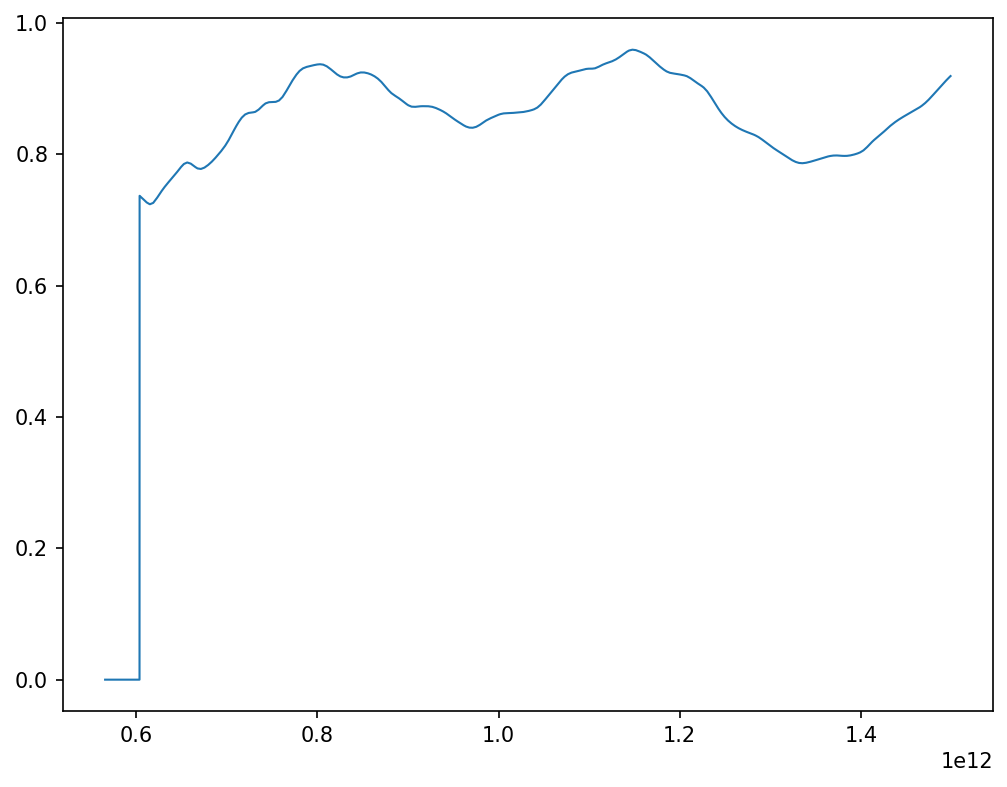

In [14]:
v_min = c/530e-6
v_max = c/200e-6
v_n   = 10000

v = np.linspace(v_min, v_max, v_n)

plt.plot(v, LPE4K_E_trans.func(v))


### Ruze loss

In [15]:
def ruze_loss(eps=5e-6,spill=0):
    
    def func(v):
        return 1 - np.exp(-(4*np.pi*eps/(c/v))**2) + spill
    
    return func

### System parameters

In [16]:
# temperature
Tprimary = 260
Tvcs2    = 175
Tvcs2f1  = 230
Tvcs1    = 70
Tvcs1f1  = 100

Tcold   = 5.0
Tcoldf1 = 10
Tfpu    = 0.25


# emissivity
emisPrimary = 0.01
emisWin  = 0.005
emisVCS2 = 0.005
emisVCS1 = 0.005
emisF4k  = 0.005
emisCold = 0.005



### Optical stack

In [18]:
bbWarm = BB('Warm', T=Tprimary)

bbVCS2 = BB('VCS2', T=Tvcs2)
bbVCS2f1 = BB('VCS2 Filter', T=Tvcs2f1)

bbVCS1 = BB('VCS1', T=Tvcs1)
bbVCS1f1 = BB('VCS1 Filter', T=Tvcs1f1)

bbCold = BB('4K', T=Tcold)
bb4kf1 =  BB('4K Filter', T=Tcoldf1)

bbFPU = BB('250mK', T=Tfpu)


Ant37  = '../atmospheric_models/models/Antarctic_DJF_34km_45deg_1.0.out'
skyNoise = Atmo('Sky Scattering', filename = Ant37 )
sky      = Atmo('Sky', filename = Ant37)


wm1 = Mirror('Primary', emissivity=emisPrimary, self_source=bbWarm, \
            spill_func=ruze_loss(eps=3e-6,spill=0.01), spill_source=skyNoise)

wm2 = Mirror('Secondary', emissivity=emisPrimary, self_source=bbWarm, \
            spill_func=ruze_loss(eps=3e-6,spill=0.01), spill_source=skyNoise)

w1 = Filter('Window', emis_func=UHMWPE_emis(thickness=0.6e-3), self_source=bbWarm, \
            refl_source=bbVCS2, trans_func=window_trans.func, spillage=0.002, spill_source=bbWarm)

fw1 = Filter('PP scattering', emis_func=PP_emis(thickness=0.1*0.5e-3), self_source=bbWarm, \
            refl_source=bbVCS2, trans_func=IR300_trans.func, spillage=0.002, spill_source=bbWarm)

fv21 = Filter('VCS2 IR Filter', emis_func=PP_emis(thickness=4e-6), self_source=bbVCS2f1, \
            refl_source=bbVCS1, trans_func=IRVCS_trans.func, spillage=0.002, spill_source=bbWarm)

fv22 = Filter('VCS2 LPE Filter', emis_func=PP_emis(thickness=4e-6), self_source=bbVCS2f1, \
            refl_source=bbVCS1, trans_func=LPEVCS_trans.func, spillage=0.00, spill_source=bbWarm)

fv11 = Filter('VCS1 IR Filter', emis_func=PP_emis(thickness=4e-6), self_source=bbVCS1f1, \
            refl_source=bbCold, trans_func=IRVCS_trans.func, spillage=0.01, spill_source=bbVCS2)

f4k1  = Filter('4K LPE Filter', emis_func=PP_emis(thickness=4e-6), self_source=bb4kf1, \
            refl_source=bbCold, trans_func=LPE4K_E_trans.func, spillage=0.00, spill_source=bbVCS1)

cm1 = Mirror('Offner', emissivity=emisCold, self_source=bbCold, \
            spill_func=ruze_loss(eps=3e-6,spill=0.15), spill_source=bbCold)

cm2 = Mirror('Offner', emissivity=emisCold, self_source=bbCold, \
            spill_func=ruze_loss(eps=3e-6,spill=0.15), spill_source=bbCold)

cm3 = Mirror('Offner', emissivity=emisCold, self_source=bbCold, \
            spill_func=ruze_loss(eps=3e-6,spill=0.05), spill_source=bbCold)

cm4 = Mirror('Offner', emissivity=emisCold, self_source=bbCold, \
            spill_func=ruze_loss(eps=3e-6,spill=0.05), spill_source=bbCold)

cm5 = Mirror('Collimator', emissivity=emisCold, self_source=bbCold, \
            spill_func=ruze_loss(eps=3e-6,spill=0.05), spill_source=bbCold)

cm6 = Mirror('Collimator', emissivity=emisCold, self_source=bbCold, \
            spill_func=ruze_loss(eps=3e-6,spill=0.05), spill_source=bbCold)

cm7 = Mirror('Collimator', emissivity=emisCold, self_source=bbCold, \
            spill_func=ruze_loss(eps=3e-6,spill=0.05), spill_source=bbCold)

f4k2 = Filter('4K LPE Filter Grating Entrance', emis_func=PP_emis(thickness=4e-6), self_source=bb4kf1, \
            refl_source=bbCold, trans_func=LPE4K_G_trans.func, spillage=0.00, spill_source=bbCold)

cm8 = Grating('Grating', emissivity=emisCold, self_source=bbCold, \
            spill_func=blazeEff.func, spill_source=bbCold)  

cm9 = Mirror('Camera Mirror', emissivity=emisCold, self_source=bbCold, \
            spill_func=ruze_loss(eps=3e-6,spill=0.05), spill_source=bbCold)

f025k1 = Filter('250mK Filter', emissivity=emisF4k, self_source=bb4kf1, \
            refl_source=bbFPU, trans_func=F42icm_trans.func, spillage=0.02, spill_source=bbCold)

f025k2 = Filter('250mK Filter', emissivity=emisF4k, self_source=bb4kf1, \
            refl_source=bbFPU, transmission=0.96, spillage=0.00, spill_source=bbCold)

layers = [wm1,wm2,w1,fw1,fv21,fv22,fv11,f4k1,cm1,cm2,cm3,cm4,cm5,cm6,cm7,f4k2, cm8,cm9,f025k1,f025k2]
sources = [sky,skyNoise,bbWarm,bbVCS2,bbVCS2f1,bbVCS1,bbVCS1f1,bbCold,bb4kf1,bbFPU]

stack = OpticalStack(layers,sources)


In [19]:
v_min = c/530e-6
v_max = c/200e-6
v_n   = 10000

v = np.linspace(v_min, v_max, v_n)

lamb = c/v
eff = stack.eff_cal(v)

#### Radiance across the band

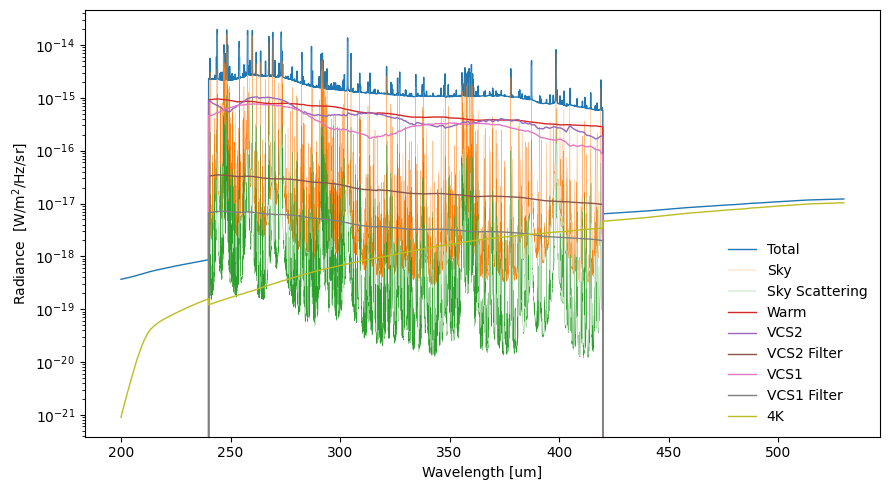

In [20]:

plt.figure(figsize=(9,5), dpi=100)

plt.plot(lamb/1e-6, stack.radiance(c/lamb,),label='Total')

for source in sources[:-2]:
    if isinstance(source, Atmo):
        plt.plot(lamb/1e-6, stack.radiance(c/lamb,source=source),lw=0.2, label=source.name)
    else:
        plt.plot(lamb/1e-6, stack.radiance(c/lamb,source=source), label=source.name)


plt.xlabel('Wavelength [um]')
plt.ylabel(r'Radiance  [W/$\rm{m^2}$/Hz/sr]')

# plt.ylim([1e-17,1e-13])
plt.yscale("log")
plt.legend(frameon=0)
plt.tight_layout()

# plt.savefig("TIM_radiance.png", dpi=120)

#### End to End Efficiency

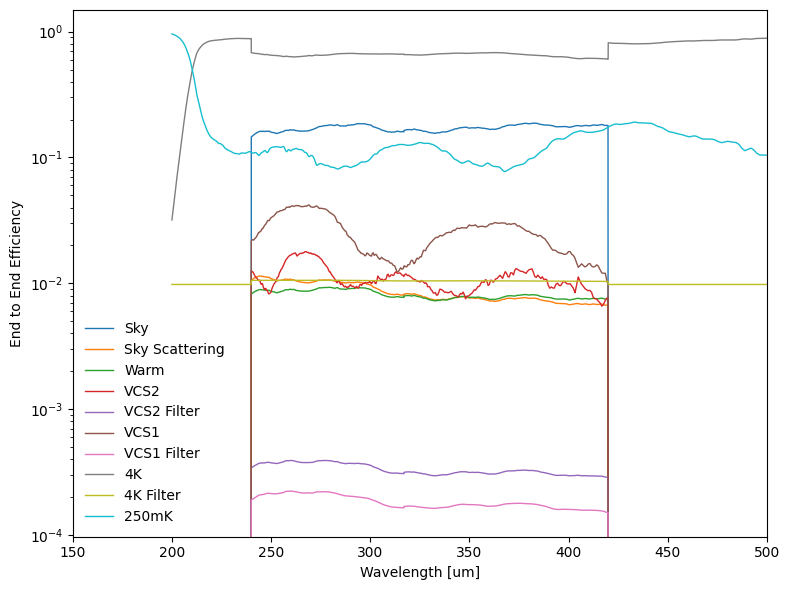

In [21]:
plt.figure(figsize=(8,6), dpi=100)

for i,source in enumerate(stack.sources):
    plt.plot(lamb/1e-6, stack.efficiency[i], label=source.name)

plt.xlim([150,500])
plt.yscale("log")

plt.ylabel("End to End Efficiency")
plt.xlabel('Wavelength [um]')

plt.legend(frameon=0)
plt.tight_layout()

In [22]:
SWlambMin = 240e-6
SWlambMax = 317e-6
LWlambMin = 317e-6
LWlambMax = 420e-6

SW_n    = 63*2
LW_n    = 63*2

SWdetectors = np.logspace(np.log10(c/SWlambMax),np.log10(c/SWlambMin), num=SW_n+1)
LWdetectors = np.logspace(np.log10(c/LWlambMax),np.log10(c/LWlambMin), num=LW_n+1)

SWbandpass = PixelBandpass(SWdetectors)
LWbandpass = PixelBandpass(LWdetectors)

SWbandpass.getBandpass(v)
LWbandpass.getBandpass(v)

detectors = np.concatenate((LWdetectors, SWdetectors))
pixelBandpass =  LWbandpass + SWbandpass

Text(0.5, 0, 'Wavelength [um]')

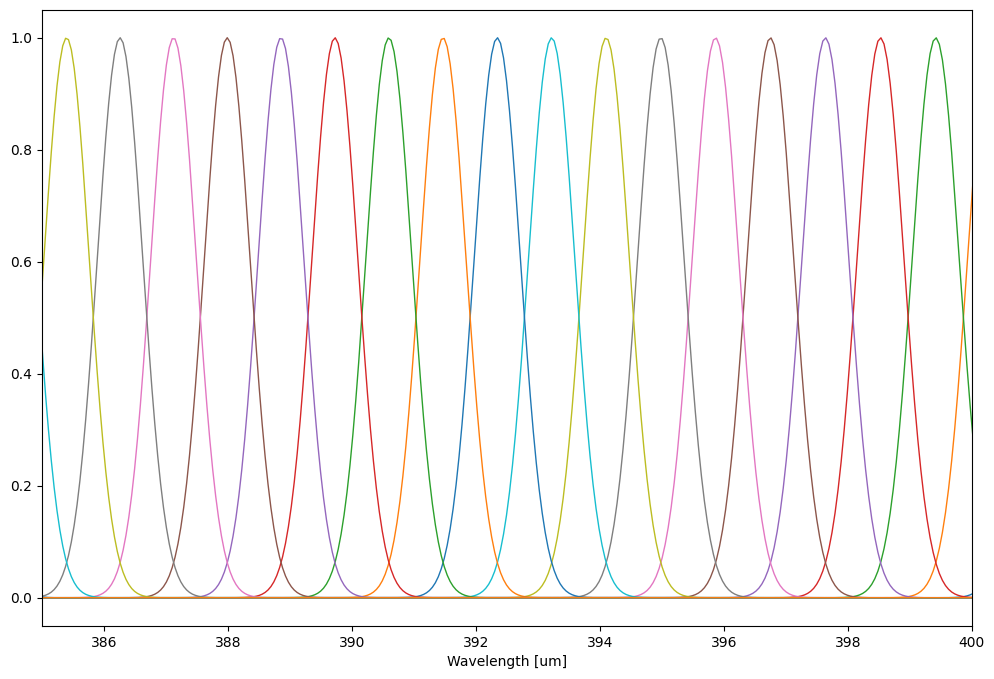

In [23]:
bandpasses = pixelBandpass.bandpass

plt.figure(figsize=(12,8), dpi=100)

for band in bandpasses:
    plt.plot(lamb*1e6, band)


plt.xlim(385,400)

plt.xlabel('Wavelength [um]')
# plt.ylabel('radiance [W/m^2/Hz/sr]')

# plt.savefig('slim_slit.png')

Text(0.5, 0, 'Wavelength [um]')

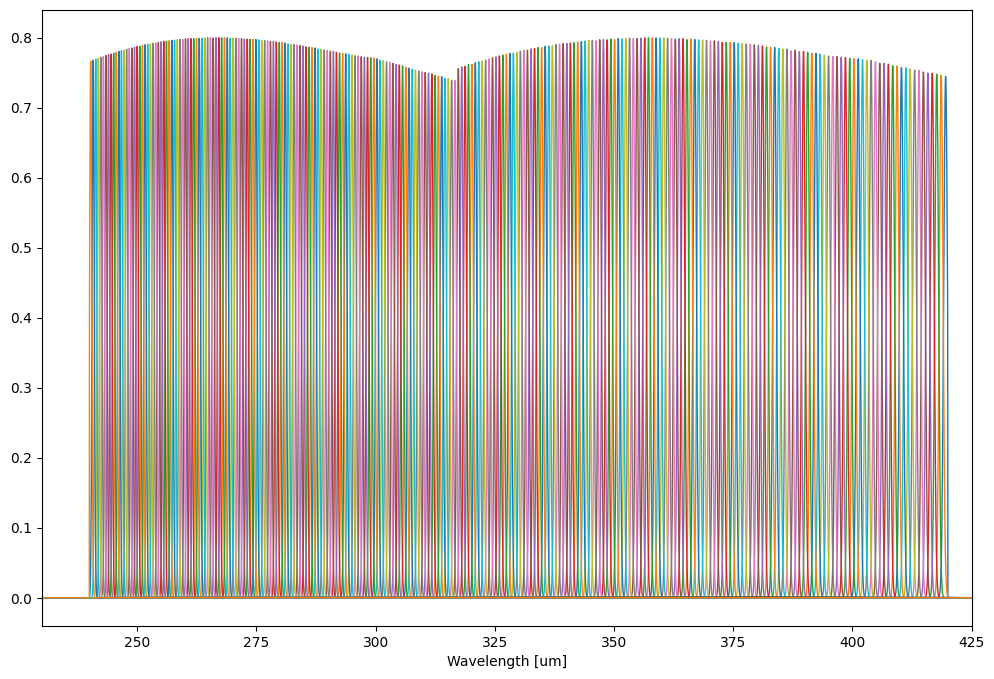

In [29]:


plt.figure(figsize=(12,8), dpi=100)

for band in bandpasses:
    plt.plot(lamb*1e6, band*(1-blazeEff.func(c/lamb)))


plt.xlim(230,425)
plt.xlabel('Wavelength [um]')
# plt.ylabel('radiance [W/m^2/Hz/sr]')
    

#### loading on the detectors

/var/folders/c3/_vf962311jd2vsq4sxvbcs6c0000gp/T/ipykernel_1918/1248928229.py:123: RuntimeWarning: divide by zero encountered in divide
  return np.exp(-(x - mu)**2 / (2 * sig**2))


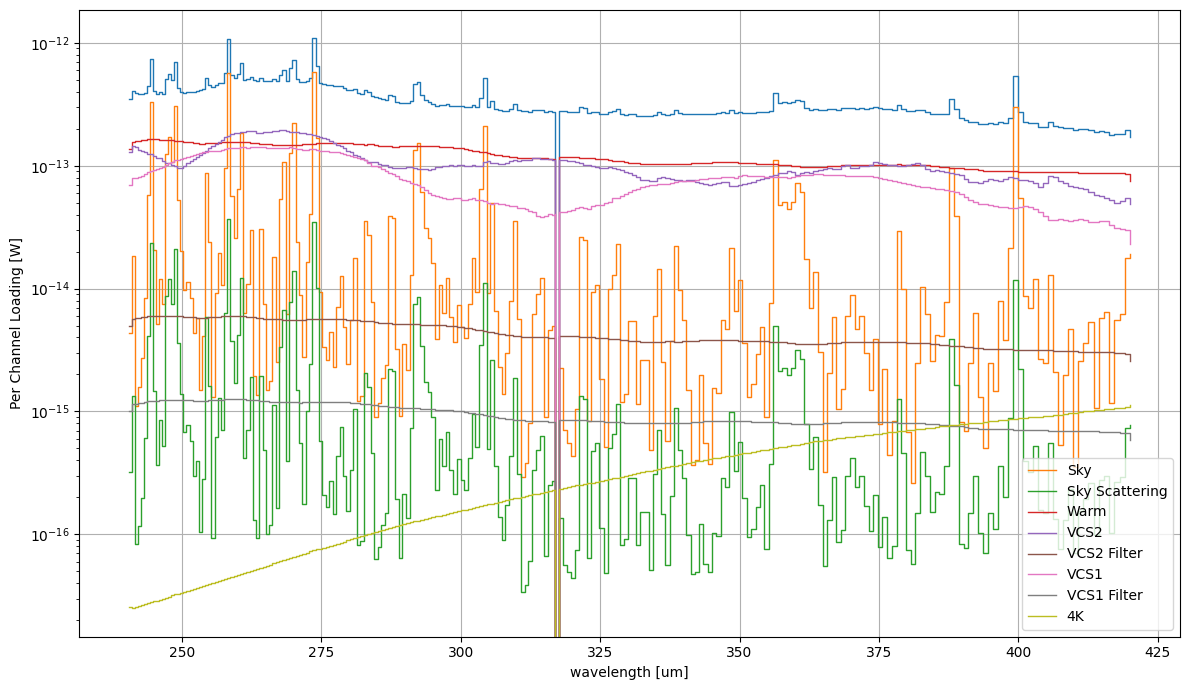

In [26]:
fig,axs = plt.subplots(1,1,figsize=(12,7), dpi=100)

plt.step(c/detectors[:-1]*1e6, stack.loading(c/lamb, bandpass=pixelBandpass), lw=1)

for source in sources[:-2]:
    plt.step(c/detectors[:-1]*1e6, stack.loading(c/lamb, bandpass=pixelBandpass, source=source), label=source.name)

plt.xlabel('wavelength [um]')
plt.ylabel('Per Channel Loading [W]')
plt.yscale("log")

plt.legend()
plt.grid()



plt.tight_layout()

plt.show()

/var/folders/c3/_vf962311jd2vsq4sxvbcs6c0000gp/T/ipykernel_732/2429792537.py:123: RuntimeWarning: divide by zero encountered in divide
  return np.exp(-(x - mu)**2 / (2 * sig**2))


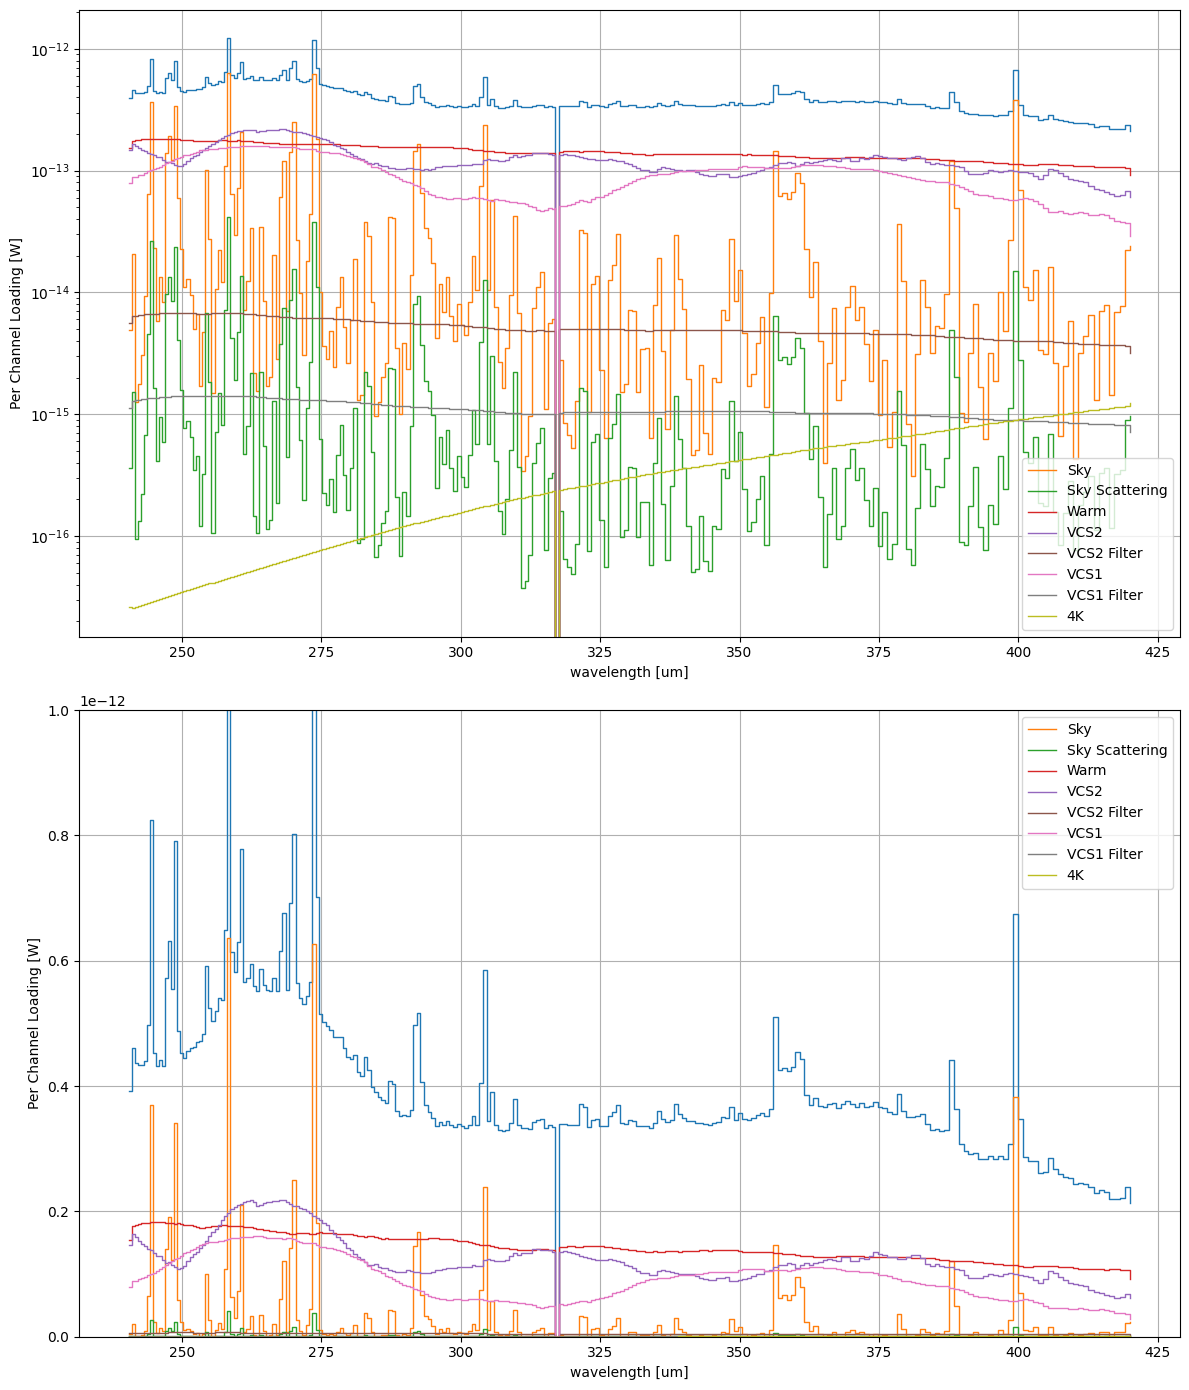

In [32]:
fig,axs = plt.subplots(2,1,figsize=(12,14), dpi=100)

axs[0].step(c/detectors[:-1]*1e6, stack.loading(c/lamb, bandpass=pixelBandpass), lw=1)
axs[1].step(c/detectors[:-1]*1e6, stack.loading(c/lamb, bandpass=pixelBandpass), lw=1)

for source in sources[:-2]:
    axs[0].step(c/detectors[:-1]*1e6, stack.loading(c/lamb, bandpass=pixelBandpass, source=source), label=source.name)
    axs[1].step(c/detectors[:-1]*1e6, stack.loading(c/lamb, bandpass=pixelBandpass, source=source), label=source.name)

axs[0].set_xlabel('wavelength [um]')
axs[0].set_ylabel('Per Channel Loading [W]')
axs[0].set_yscale("log")

axs[0].legend()
axs[0].grid()

axs[1].set_xlabel('wavelength [um]')
axs[1].set_ylabel('Per Channel Loading [W]')
# axs[1].set_yscale("log")
axs[1].set_ylim([0,1e-12])

axs[1].legend()
axs[1].grid()

plt.tight_layout()

plt.show()

### End to end efficiency at each stage

In [27]:
idx_max = (np.abs(lamb - 240e-6)).argmin()
idx_min =  (np.abs(lamb - 420e-6)).argmin()

eff = []

for item in stack.stack:
    eff.append((np.mean(item.efficiency[:,idx_min:idx_max], axis=1)))

eff = np.array(eff)

effTable = pd.DataFrame(eff, index=[item.name for item in stack.stack], columns=[source.name for source in sources])
effTable['Total'] = effTable.sum(axis=1)

effTable

,Sky,Sky Scattering,Warm,VCS2,VCS2 Filter,VCS1,VCS1 Filter,4K,4K Filter,250mK,Total
Primary,0.964778,0.025222,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Secondary,0.930819,0.049533,0.019648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
Window,0.900281,0.047852,0.029631,0.022237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
PP scattering,0.867424,0.046070,0.040368,0.046138,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
VCS2 IR Filter,0.821156,0.043508,0.040069,0.043609,0.000796,0.050863,0.000000,0.000000,0.000000,0.000000,1.0
VCS2 LPE Filter,0.763846,0.040386,0.037237,0.040324,0.001535,0.116672,0.000000,0.000000,0.000000,0.000000,1.0
VCS1 IR Filter,0.717526,0.037846,0.034942,0.047305,0.001440,0.109285,0.000796,0.050863,0.000000,0.000000,1.0
4K LPE Filter,0.644152,0.034039,0.031393,0.042673,0.001295,0.099244,0.000716,0.145693,0.000796,0.000000,1.0
Offner,0.535012,0.028240,0.026061,0.035416,0.001075,0.082325,0.000594,0.290617,0.000660,0.000000,1.0
Offner,0.444377,0.023430,0.021635,0.029394,0.000892,0.068293,0.000493,0.410937,0.000548,0.000000,1.0


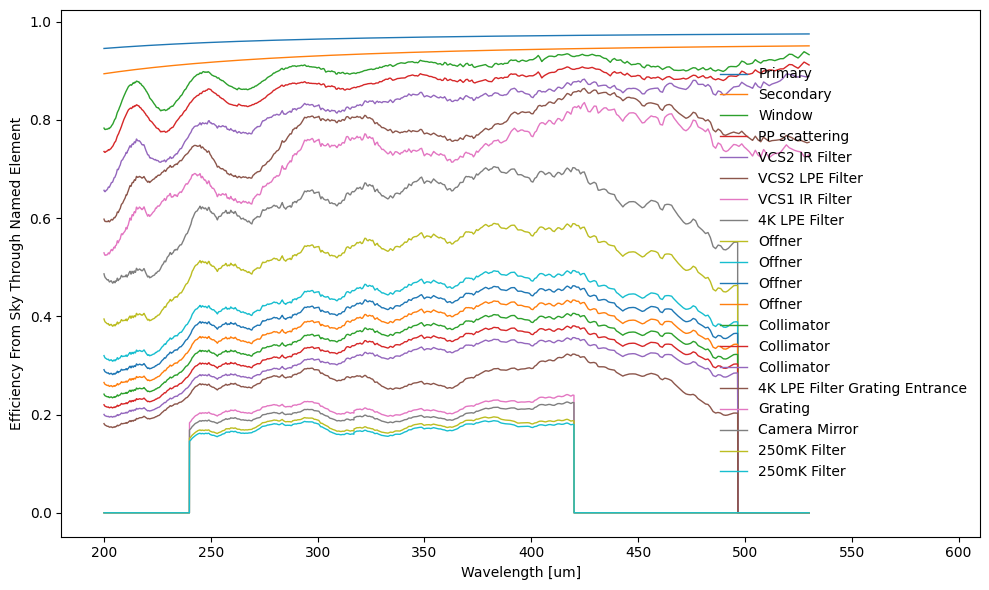

In [28]:
fig,ax=plt.subplots(figsize=(10,6), dpi=100)

for item in stack.stack:
    plt.plot(lamb*1e6, (item.efficiency[0,:]), label=item.name)

plt.xlim([180,610])
# plt.xscale('log')

plt.ylabel("Efficiency From Sky Through Named Element")
plt.xlabel('Wavelength [um]')

plt.legend(frameon=0)
plt.tight_layout()